# Figure 2
## Layered plot of multiple data products and calculations provided by Siphon and MetPy
Adapted from https://github.com/Unidata/metpy-workshop/blob/main/notebooks/solutions/workshop_solutions.ipynb.

In [1]:
from datetime import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib.patheffects import withStroke

import metpy.calc as mpcalc
import metpy.plots as mpplots
from metpy.io import parse_metar_file
from metpy.units import pandas_dataframe_to_unit_arrays
from siphon.catalog import TDSCatalog

Access near-real-time satellite data remotely from UCAR/Unidata's THREDDS Data Server (TDS).

In [2]:
satcat = TDSCatalog(
    "https://thredds.ucar.edu/thredds/catalog/satellite/goes/east/products/CloudAndMoistureImagery/CONUS/Channel02/current/catalog.xml"
)
satdata = satcat.datasets[0].remote_access(use_xarray=True)

cmi = satdata.metpy.parse_cf("Sectorized_CMI")
dt = datetime.strptime(satdata.attrs["start_date_time"], "%Y%j%H%M%S")

Access Real Time Mesoscale Analysis (RTMA) output remotely from the same TDS.

In [3]:
rtma_cat = TDSCatalog(
    "https://thredds.ucar.edu/thredds/catalog/grib/NCEP/RTMA/CONUS_2p5km/catalog.xml"
)
rtma_data = rtma_cat.datasets["Full Collection Dataset"].remote_access(use_xarray=True)
rtma_data = rtma_data.metpy.parse_cf().squeeze()

In [4]:
pres = rtma_data["Pressure_Analysis_surface"].metpy.sel(time=dt, method="nearest")
temp = rtma_data["Temperature_Analysis_height_above_ground"].metpy.sel(
    time=dt, method="nearest"
)
dewp = rtma_data["Dewpoint_temperature_Analysis_height_above_ground"].metpy.sel(
    time=dt, method="nearest"
)

theta_e = mpcalc.equivalent_potential_temperature(pres, temp, dewp)

theta_e = mpcalc.smooth_gaussian(theta_e, n=50)

rtma_crs = theta_e.metpy.cartopy_crs

/Users/dcamron/mambaforge/envs/bams-manuscript/lib/python3.10/site-packages/metpy/xarray.py:355: UserWarning: More than one vertical coordinate present for variable "Pressure_Analysis_surface".
  warnings.warn('More than one ' + axis + ' coordinate present for variable'


Access near-real-time surface observations as text METAR reports from Unidata's THREDDS-test testing TDS.

In [5]:
metar_cat = TDSCatalog(
    "https://thredds-test.unidata.ucar.edu/thredds/catalog/noaaport/text/metar/catalog.xml"
)
metar_text = metar_cat.datasets.filter_time_nearest(dt).remote_open(mode="t")

sfc_data = parse_metar_file(metar_text, year=dt.year, month=dt.month)
sfc_units = sfc_data.units

sfc_data = pandas_dataframe_to_unit_arrays(sfc_data, sfc_units)

In [6]:
locs = rtma_crs.transform_points(
    ccrs.PlateCarree(), sfc_data["longitude"].m, sfc_data["latitude"].m
)

plot_mask = mpcalc.reduce_point_density(
    locs[..., :2], 175000, priority=sfc_data["current_wx1_symbol"]
)

/Users/dcamron/mambaforge/envs/bams-manuscript/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


FileNotFoundError: [Errno 2] No such file or directory: 'images/fig2_multilayer.png'

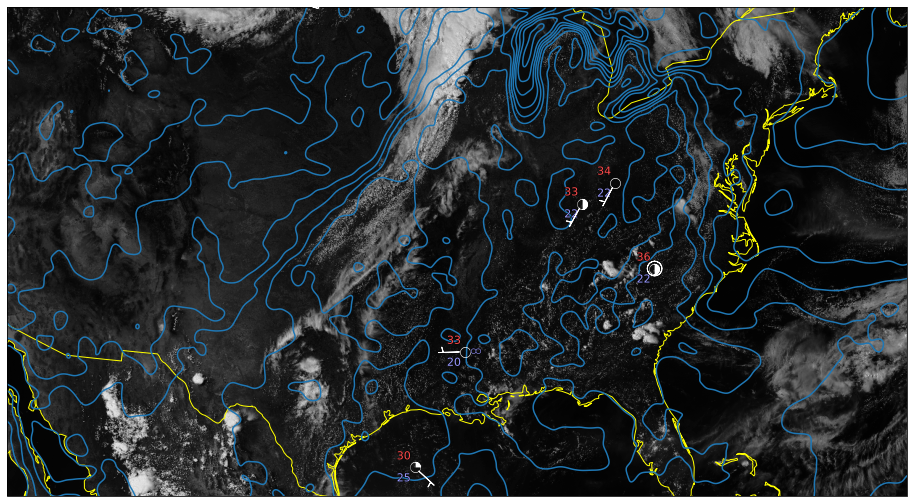

In [7]:
fig = plt.figure(figsize=(18, 9))
ax = fig.add_subplot(projection=rtma_crs)

image_extent = (cmi.metpy.x[0], cmi.metpy.x[-1], cmi.metpy.y[0], cmi.metpy.y[-1])
ax.imshow(
    cmi,
    extent=image_extent,
    origin="lower",
    cmap="Greys_r",
    regrid_shape=6000,
    transform=cmi.metpy.cartopy_crs,
)

ax.contour(
    theta_e.metpy.x,
    theta_e.metpy.y,
    theta_e,
    levels=range(240, 400, 8),
    colors="tab:blue",
    transform=theta_e.metpy.cartopy_crs,
)

stn = mpplots.StationPlot(
    ax,
    sfc_data["longitude"][plot_mask].m,
    sfc_data["latitude"][plot_mask].m,
    transform=ccrs.PlateCarree(),
    fontsize=11,
    zorder=10,
    clip_on=True,
)
stn.plot_parameter(
    "NW",
    sfc_data["air_temperature"][plot_mask],
    color=[1.0, 0.3, 0.3],
    path_effects=[withStroke(linewidth=1, foreground="black")],
)
stn.plot_parameter(
    "SW",
    sfc_data["dew_point_temperature"][plot_mask],
    color=[0.6, 0.6, 1.0],
    path_effects=[withStroke(linewidth=1, foreground="black")],
)
stn.plot_symbol("C", sfc_data["cloud_coverage"][plot_mask], mpplots.sky_cover, color="white")
stn.plot_symbol(
    "E",
    sfc_data["current_wx1_symbol"][plot_mask],
    mpplots.current_weather,
    color=[0.6, 0.6, 1.0],
    path_effects=[withStroke(linewidth=1, foreground="black")],
)
stn.plot_barb(
    sfc_data["eastward_wind"][plot_mask],
    sfc_data["northward_wind"][plot_mask],
    color="white",
)

ax.add_feature(cfeature.BORDERS, color="yellow")
ax.add_feature(cfeature.COASTLINE, color="yellow")
ax.set_extent((-113, -70, 25, 45))

fig.savefig("images/fig2_multilayer.png", dpi=600, bbox_inches="tight")
print(f"For caption: {dt:%H%M} UTC {dt:%d %B %Y}")

### Draft caption
Map of the continental U.S. with background GOES-16 Channel 02 imagery, overlayed with contours of potential temperature calculated from Real-Time Mesoscale Analysis (RTMA) output and station models of surface observations from a collection of surface observation METARs. All products valid {date of production}.